# MEDICAL TEXT CLASSIFICATION USING GRU MODEL WITH MULTIPLE EMBEDDINGS

## Objective
Multi-class medical symptom classification using GRU with four different embedding approaches:
1. TF-IDF
2. Word2Vec
3. GloVe
4. FastText

## Key Dataset Decisions
- **Task**: Multi-class medical symptom classification
- **Input**: Tokenized clinical descriptions
- **Evaluation metrics**: Accuracy + Macro F1
- **Labels**: Integer-encoded for compatibility with cross-entropy loss

# Imports & Configurations

In [1]:
import os
import requests, zipfile, io
import pandas as pd
from collections import Counter
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from gensim.models import FastText
import matplotlib.pyplot as plt

%matplotlib inline

2026-02-06 16:01:49.739767: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-06 16:01:51.037802: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-06 16:01:53.963665: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## Download NLTK resources

Download NLTK resources like stopwords and wordnet beforehand

In [2]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/degide/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/degide/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Preprocessing


## Define custom medical stopwords

These add noise to the system classifying medical text

In [ ]:
# Define custom medical stopwords
medical_stopwords = ['patient', 'doctor', 'history', 'year', 'years', 'old', 'complains', 'presented', 'hospital']
stopwords = set(stopwords.words('english')).union(set(medical_stopwords))

Next, we define the word lemmatizer

In [4]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

Utility function to preprocess raw text:

In [5]:
# Text preprocessing function
def preprocess_text(text, use_lemmatization=False):
    # Lowercase the text
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize the text
    words = text.split()
    
    # Remove stopwords
    words = [word for word in words if word not in stopwords]
    
    # Apply lemmatization if specified
    if use_lemmatization:
        words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

## Dataset loading

In this part, we load the dataset and apply the preprocessing

In [ ]:
# Load dataset
df = pd.read_csv('../dataset/medical_llm_dataset.csv')

# Apply preprocessing to the text column without lemmatization
df['clean_text'] = df['text'].apply(lambda x: preprocess_text(x, use_lemmatization=False))

Utility functions to build word vocabulary and convert text to sequenses:

In [7]:
# Build vocabulary
def build_vocabulary(text_series, max_vocab_size=5000):
    # Count all words
    all_words = [word for text in text_series for word in text.split()]
    word_counts = Counter(all_words)

    # Keep only most common words (to avoid massive memory usage)
    most_common = word_counts.most_common(max_vocab_size - 2)  # Reserve 2 spots for PAD and UNK

    # Create mapping: word -> index (int)
    vocab = {word: i+2 for i, (word, _) in enumerate(most_common)}
    vocab['<PAD>'] = 0  # Padding token
    vocab['<UNK>'] = 1  # Unknown token

    return vocab

# Convert text to sequences (Padded)
def text_to_sequence(text, vocab, max_len=50):
    tokens = text.split()

    # Convert to intergers (use <UNK> token if word not in vocab)
    seq = [vocab.get(token, vocab['<UNK>']) for token in tokens]

    # Truncate if too long
    if len(seq) > max_len:
        seq = seq[:max_len]
    # Pad if too short
    else:
        seq += [vocab['<PAD>']] * (max_len - len(seq))

    return seq

In [8]:
# --- EXECUTION ---
# Build vocabulary from cleaned/training text only (to prevent data leakage)
vocab = build_vocabulary(df['clean_text'], max_vocab_size=5000)

# Convert cleaned text to sequences
# This creates a matrix of shape (num_samples, max_len)
x_indices = np.array([text_to_sequence(text, vocab, max_len=50) for text in df['clean_text']])

print("Vocabulary Size:", len(vocab))
print("Sample sequence (first entry):", x_indices[0])

Vocabulary Size: 643
Sample sequence (first entry): [ 12   8   2  74 636  96   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## Dataset Visualizations

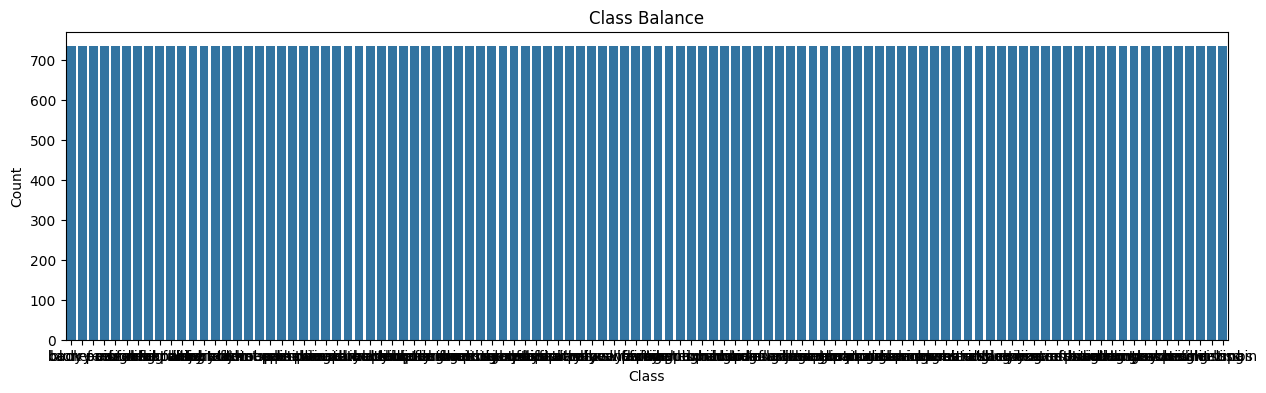

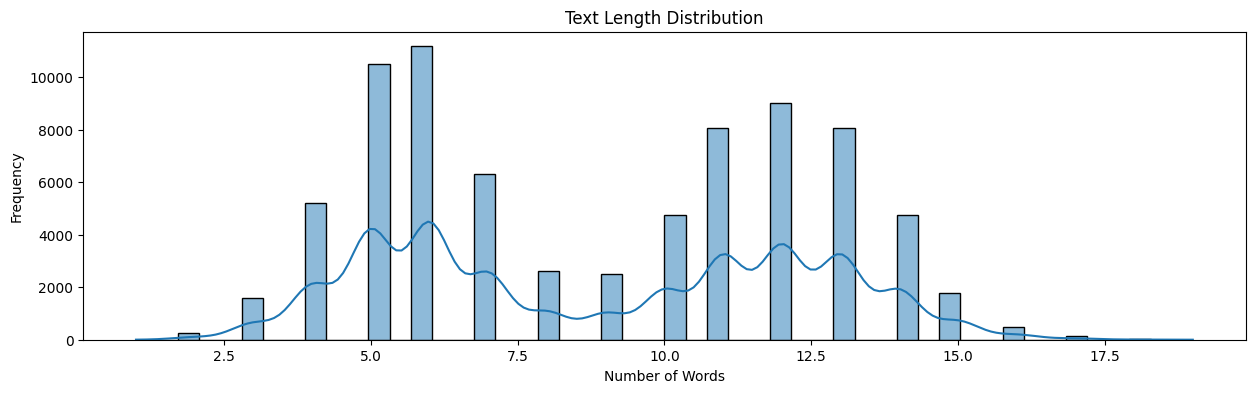

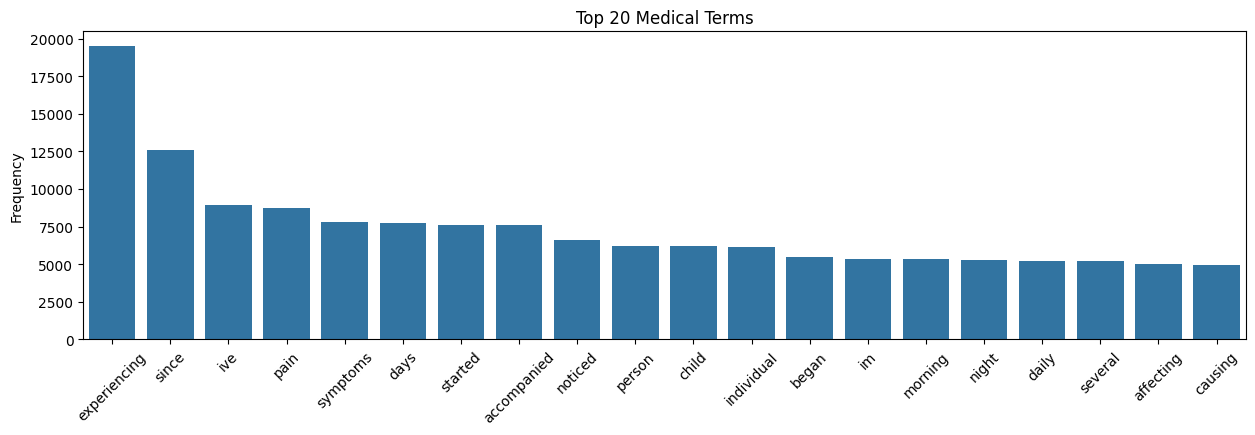

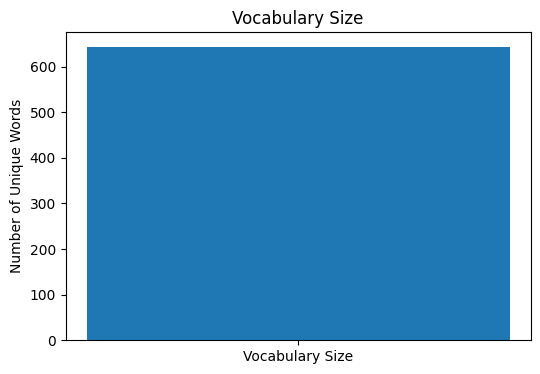

In [ ]:
# Class Balance
plt.figure(figsize=(15,4))
sns.countplot(x='label_enc', data=df)
plt.title('Class Balance')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Text Length Distribution
text_lengths = df['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(15,4))
sns.histplot(text_lengths, bins=50, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Top 20 Medical Terms
all_words = [word for text in df['clean_text'] for word in text.split()]
word_freq = Counter(all_words)
top_20 = word_freq.most_common(20)
terms, counts = zip(*top_20)
plt.figure(figsize=(15,4))
sns.barplot(x=list(terms), y=list(counts))
plt.title('Top 20 Medical Terms')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

# Vocabulary Size
plt.figure(figsize=(6,4))
plt.bar(['Vocabulary Size'], [len(vocab)])
plt.title('Vocabulary Size')
plt.ylabel('Number of Unique Words')
plt.show()

# GRU Model

In [10]:
# Build GRU Model
def build_gru_model(vocab_size, embedding_dim, input_length, embedding_matrix=None, trainable=True):
    inputs = Input(shape=(input_length,))
    if embedding_matrix is not None:
        x = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=input_length, trainable=trainable)(inputs)
    else:
        x = Embedding(vocab_size, embedding_dim, input_length=input_length)(inputs)
    x = GRU(64, return_sequences=False)(x)
    outputs = Dense(df['label_enc'].nunique(), activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
# Experiments

# Results storage
results = []

# Prepare data
X = x_indices
y = df['label_enc'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Experiments

In [12]:
# Experiment 1:  TF-IDF + GRU
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['clean_text']).toarray()
X_tfidf = pad_sequences(X_tfidf, maxlen=50)
# Use integer-encoded labels for training and evaluation
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
	X_tfidf, df['label_enc'].factorize()[0], test_size=0.1, random_state=42
)
model_tfidf = build_gru_model(X_tfidf.shape[1], 64, X_tfidf.shape[1])
model_tfidf.fit(X_train_tfidf, y_train_tfidf, epochs=2, batch_size=128, validation_split=0.2, verbose=1)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf).argmax(axis=1)
acc_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)
f1_tfidf = f1_score(y_test_tfidf, y_pred_tfidf, average='weighted')

results.append(('TF-IDF', acc_tfidf, f1_tfidf))
print("TF-IDF Results:", acc_tfidf, f1_tfidf)

Epoch 1/2


/home/degide/.mlvenv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
E0000 00:00:1770386579.031366  168205 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1770386579.039836  168205 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


435/435 ━━━━━━━━━━━━━━━━━━━━ 36s 77ms/step - accuracy: 0.0088 - loss: 4.6550 - val_accuracy: 0.0089 - val_loss: 4.6546
Epoch 2/2
435/435 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.0097 - loss: 4.6546 - val_accuracy: 0.0083 - val_loss: 4.6556
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
TF-IDF Results: 0.007255765742420316 0.00010453380025097445


In [ ]:
# Experiment 2: Skip-gram (Word2Vec) + GRU
w2v_model = Word2Vec([text.split() for text in df['clean_text']], vector_size=64, window=5, min_count=1, sg=1)
embedding_matrix = np.zeros((len(vocab), 64))
for word, i in vocab.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
model_skipgram = build_gru_model(len(vocab), 64, 50, embedding_matrix)
model_skipgram.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.1, verbose=1)
y_pred_skipgram = model_skipgram.predict(X_test).argmax(axis=1)
acc_skipgram = accuracy_score(y_test, y_pred_skipgram)
f1_skipgram = f1_score(y_test, y_pred_skipgram, average='weighted')

results.append(('Skip-gram', acc_skipgram, f1_skipgram))
print("Skip-gram Results:", acc_skipgram, f1_skipgram)

In [ ]:
# Experiment 3: GloVe + GRU
# Download GloVe embeddings (if not present)
if not os.path.exists('../dataset/glove.6B/glove.6B.100d.txt'):
    url = 'http://nlp.stanford.edu/data/glove.6B.zip'
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extract('glove.6B.100d.txt', path='../dataset/glove.6B')
glove_embeddings = {}
with open('../dataset/glove.6B/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector
embedding_matrix_glove = np.zeros((len(vocab), 100))
for word, i in vocab.items():
    if word in glove_embeddings:
        embedding_matrix_glove[i] = glove_embeddings[word]
model_glove = build_gru_model(len(vocab), 100, 50, embedding_matrix_glove)
model_glove.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.1, verbose=1)
y_pred_glove = model_glove.predict(X_test).argmax(axis=1)
acc_glove = accuracy_score(y_test, y_pred_glove)
f1_glove = f1_score(y_test, y_pred_glove, average='weighted')
results.append(('GloVe', acc_glove, f1_glove))
print("GloVe Results:", acc_glove, f1_glove)

/home/degide/.mlvenv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


ValueError: Invalid dtype: object

In [ ]:
# Experiment 4: FastText + GRU
ft_model = FastText([text.split() for text in df['clean_text']], vector_size=64, window=5, min_count=1)
embedding_matrix_ft = np.zeros((len(vocab), 64))
for word, i in vocab.items():
    if word in ft_model.wv:
        embedding_matrix_ft[i] = ft_model.wv[word]
model_ft = build_gru_model(len(vocab), 64, 50, embedding_matrix_ft)
model_ft.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.1, verbose=1)
y_pred_ft = model_ft.predict(X_test).argmax(axis=1)
acc_ft = accuracy_score(y_test, y_pred_ft)
f1_ft = f1_score(y_test, y_pred_ft, average='weighted')
results.append(('FastText', acc_ft, f1_ft))
print("FastText Results:", acc_ft, f1_ft)

Epoch 1/3
489/489 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - accuracy: 0.0095 - loss: 4.6548 - val_accuracy: 0.0105 - val_loss: 4.6542
Epoch 2/3
489/489 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - accuracy: 0.0096 - loss: 4.6548 - val_accuracy: 0.0078 - val_loss: 4.6551
Epoch 3/3
489/489 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - accuracy: 0.0092 - loss: 4.6546 - val_accuracy: 0.0098 - val_loss: 4.6551
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


ValueError: Found input variables with inconsistent numbers of samples: [15435, 7718]

In [ ]:
# Save results to CSV
results_df = pd.DataFrame(results, columns=['Embedding_Method', 'Accuracy', 'F1_Score'])
results_df.to_csv('../results/gru_experiment_results.csv', index=False)